Reproduce Fig2: Pearson based and STTC based area ACFs and timescales.

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, OptimizeWarning
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
fig_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fig_drafts\\'

### Get the data

In [3]:
results_folder = 'D:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fixation_period_1000ms\\'

#### ACF

In [4]:
pfdl_dataset_constraints_df = pd.read_pickle(results_folder + 'pfdl_dataset_constraints_df.pkl')
pfp_dataset_constraints_df = pd.read_pickle(results_folder + 'pfp_dataset_constraints_df.pkl')

In [22]:
def load_constraints_acf_df(file_name_, dataset_constraints_df_):
    pfdl_acf_average_trial_pearsonr_df = pd.read_pickle(results_folder + file_name_ + '.pkl')    
    # # get subsets based on constraints 
    # dataset_constraints_subset_df = dataset_constraints_df_.query('n_trials_more_20 == True and no_zero_bins == 1 and one_hz_activity == 1').copy()
    
    # # join
    # pfdl_acf_average_trial_pearsonr_subset_df = dataset_constraints_subset_df.merge(pfdl_acf_average_trial_pearsonr_df, 
    #                                                                               on='unit_id', how='left')
    # pfdl_acf_average_trial_pearsonr_subset_df.reset_index(inplace=True, drop=True)
    
    
    # # check NaNs
    
    # # print('N neurons: {}'.format(len(pfdl_acf_average_trial_pearsonr_subset_df)))
    
    # # print('NaNs in PFdl acf {}'.format(pfdl_acf_average_trial_pearsonr_subset_df.isnull().any().any()))

    # return pfdl_acf_average_trial_pearsonr_subset_df
    return pfdl_acf_average_trial_pearsonr_df

In [23]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags)]

In [31]:
trials_folder = 'trials20'

In [32]:
# for pfdl pearson
n_runs = 50

pfdl_pearson_tau_ms_l, pfdl_pearson_fit_r_squared_l = [], []
for i in range(n_runs):
    file_name = 'binned\\pfdl\\acf\\' + trials_folder + '\\acf_average_trial_pearsonr_with_empty_50ms_20lags_df' + str(i)
    acf_df = load_constraints_acf_df(file_name, pfdl_dataset_constraints_df)
    acf_2d = acf_df[acf_cols].values
    acf_mean = np.nanmean(acf_2d, axis=0)
    tau, popt, fit_r_squared = calc_tau_area_mean(acf_mean, start_idx_=2)
    tau_ms = tau*50
    #print('tau {}, popt {}, fit_r_squared {}'.format(tau_ms, popt, fit_r_squared))
    pfdl_pearson_tau_ms_l.append(tau_ms)
    pfdl_pearson_fit_r_squared_l.append(fit_r_squared)

In [33]:
# for pfdl sttc
n_runs = 50

pfdl_sttc_tau_ms_l, pfdl_sttc_fit_r_squared_l = [], []
for i in range(n_runs):
    file_name = 'non_binned\\pfdl\\acf\\' + trials_folder + '\\acf_average_trial_sttc_with_empty_50ms_20lags_51padding_df' + str(i)
    acf_df = load_constraints_acf_df(file_name, pfdl_dataset_constraints_df)
    acf_2d = acf_df[acf_cols].values
    acf_mean = np.nanmean(acf_2d, axis=0)
    tau, popt, fit_r_squared = calc_tau_area_mean(acf_mean, start_idx_=2)
    tau_ms = tau*50
    #print('tau {}, popt {}, fit_r_squared {}'.format(tau_ms, popt, fit_r_squared))
    pfdl_sttc_tau_ms_l.append(tau_ms)
    pfdl_sttc_fit_r_squared_l.append(fit_r_squared)

In [34]:
# for pfp pearson
n_runs = 50

pfp_pearson_tau_ms_l, pfp_pearson_fit_r_squared_l = [], []
for i in range(n_runs):
    file_name = 'binned\\pfp\\acf\\' + trials_folder + '\\acf_average_trial_pearsonr_with_empty_50ms_20lags_df' + str(i)
    acf_df = load_constraints_acf_df(file_name, pfdl_dataset_constraints_df)
    acf_2d = acf_df[acf_cols].values
    acf_mean = np.nanmean(acf_2d, axis=0)
    tau, popt, fit_r_squared = calc_tau_area_mean(acf_mean, start_idx_=2)
    tau_ms = tau*50
    #print('tau {}, popt {}, fit_r_squared {}'.format(tau_ms, popt, fit_r_squared))
    pfp_pearson_tau_ms_l.append(tau_ms)
    pfp_pearson_fit_r_squared_l.append(fit_r_squared)

In [35]:
# for pfp sttc
n_runs = 50

pfp_sttc_tau_ms_l, pfp_sttc_fit_r_squared_l = [], []
for i in range(n_runs):
    file_name = 'non_binned\\pfp\\acf\\' + trials_folder + '\\acf_average_trial_sttc_with_empty_50ms_20lags_51padding_df' + str(i)
    acf_df = load_constraints_acf_df(file_name, pfdl_dataset_constraints_df)
    acf_2d = acf_df[acf_cols].values
    acf_mean = np.nanmean(acf_2d, axis=0)
    tau, popt, fit_r_squared = calc_tau_area_mean(acf_mean, start_idx_=2)
    tau_ms = tau*50
    #print('tau {}, popt {}, fit_r_squared {}'.format(tau_ms, popt, fit_r_squared))
    pfp_sttc_tau_ms_l.append(tau_ms)
    pfp_sttc_fit_r_squared_l.append(fit_r_squared)

### Calculate tau

In [9]:
def func_single_exp(x, a, b, c):
    """
    Exponential function to fit the data.
    :param x: 1d array, independent variable
    :param a: float, parameter to fit
    :param b: float, parameter to fit
    :param c: float, parameter to fit
    :return: callable
    """
    #return a * np.exp(-b * x) + c
    return a * (np.exp(-b * x) + c) # as in the paper

In [10]:
def calc_tau_area_mean(acf_mean_, start_idx_=1):    
    t = np.linspace(0, len(acf_mean_)-1, len(acf_mean_)).astype(int)
    # print(t)
    
    popt, pcov = curve_fit(func_single_exp, t[start_idx_:], acf_mean_[start_idx_:], maxfev=1000000000) # I used 5000, now it is like in Siegle
    tau = 1 / popt[1]
    
    # fit r-squared
    y_pred = func_single_exp(t[start_idx_:], *popt)
    fit_r_squared = r2_score(acf_mean_[start_idx_:], y_pred)

    return tau, popt, fit_r_squared

### Plot

In [19]:
save_fig = True

In [37]:
pfp_sttc_tau_ms_l = [tau for tau in pfp_sttc_tau_ms_l if tau > 0]

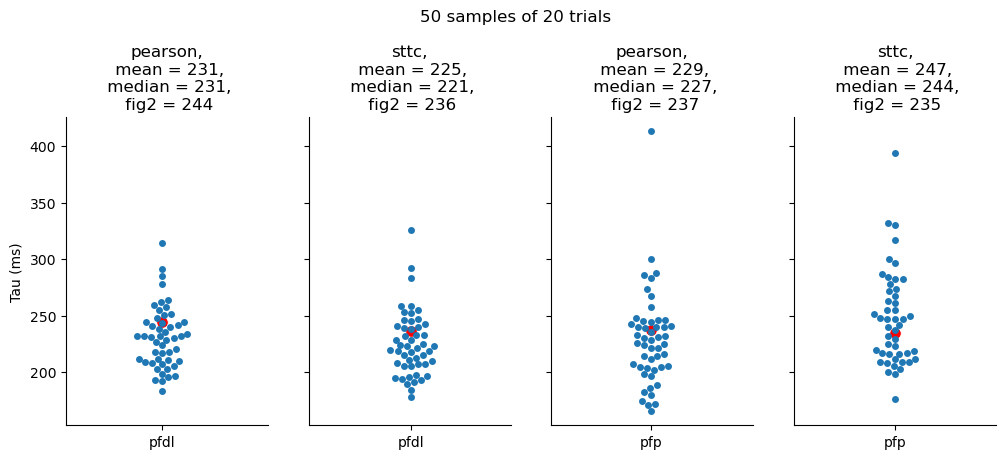

In [38]:
fig, axes = plt.subplots(1,4, figsize=(12,4), sharey=True)

sns.swarmplot(ax=axes[0], x=['pfdl']*len(pfdl_pearson_tau_ms_l), y=np.asarray(pfdl_pearson_tau_ms_l))
sns.swarmplot(ax=axes[1], x=['pfdl']*len(pfdl_sttc_tau_ms_l), y=np.asarray(pfdl_sttc_tau_ms_l))
axes[0].set_ylabel('Tau (ms)')
axes[0].set_title('pearson,\n mean = ' + str(int(np.mean(np.asarray(pfdl_pearson_tau_ms_l)))) + ',\n median = ' 
                  + str(int(np.median(np.asarray(pfdl_pearson_tau_ms_l)))) + ',\n fig2 = 244')
axes[1].set_title('sttc,\n mean = ' + str(int(np.mean(np.asarray(pfdl_sttc_tau_ms_l)))) + ',\n median = ' 
                  + str(int(np.median(np.asarray(pfdl_sttc_tau_ms_l)))) + ',\n fig2 = 236')

sns.scatterplot(ax=axes[0], x=['pfdl'], y=244, color='red',s=70)
sns.scatterplot(ax=axes[1], x=['pfdl'], y=236, color='red', s=70)

sns.swarmplot(ax=axes[2], x=['pfp']*len(pfp_pearson_tau_ms_l), y=np.asarray(pfp_pearson_tau_ms_l))
sns.swarmplot(ax=axes[3], x=['pfp']*len(pfp_sttc_tau_ms_l), y=np.asarray(pfp_sttc_tau_ms_l))
axes[2].set_title('pearson,\n mean = ' + str(int(np.mean(np.asarray(pfp_pearson_tau_ms_l)))) + ',\n median = ' 
                  + str(int(np.median(np.asarray(pfp_pearson_tau_ms_l)))) + ',\n fig2 = 237')
axes[3].set_title('sttc,\n mean = ' + str(int(np.mean(np.asarray(pfp_sttc_tau_ms_l)))) + ',\n median = ' 
                  + str(int(np.median(np.asarray(pfp_sttc_tau_ms_l)))) + ',\n fig2 = 235')

sns.scatterplot(ax=axes[2], x=['pfp'], y=237, color='red',s=70)
sns.scatterplot(ax=axes[3], x=['pfp'], y=235, color='red',s=70)

fig.suptitle('50 samples of 20 trials', y=1.15)

sns.despine()

if save_fig:
    fig.savefig(fig_folder + 'trial20_50samples_pearson_and_sttc_with_empty_0_1000_51padding_full_dataset.png', bbox_inches='tight')
    fig.savefig(fig_folder + 'trial20_50samples_pearson_and_sttc_with_empty_0_1000_51padding_full_dataset.svg', bbox_inches='tight')

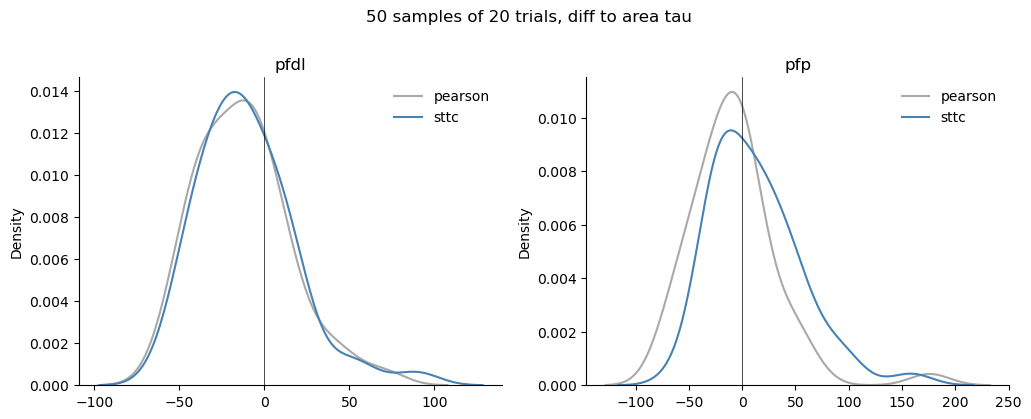

In [39]:
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=False)

sns.kdeplot(ax=axes[0], x=np.asarray(pfdl_pearson_tau_ms_l)-244, c='darkgrey', label='pearson')
sns.kdeplot(ax=axes[0], x=np.asarray(pfdl_sttc_tau_ms_l)-236, c='steelblue', label='sttc')
axes[0].set_title('pfdl')

sns.kdeplot(ax=axes[1], x=np.asarray(pfp_pearson_tau_ms_l)-237, c='darkgrey', label='pearson')
sns.kdeplot(ax=axes[1], x=np.asarray(pfp_sttc_tau_ms_l)-235, c='steelblue', label='sttc')
axes[1].set_title('pfp')

fig.suptitle('50 samples of 20 trials, diff to area tau', y=1.05)

for ax in axes.flat:
    ax.axvline(x=0, lw=0.5, c='k')
    ax.legend(frameon=False)

sns.despine()

if save_fig:
    fig.savefig(fig_folder + 'trial20_50samples_diff_pearson_and_sttc_with_empty_0_1000_51padding_full_dataset.png', bbox_inches='tight')
    fig.savefig(fig_folder + 'trial20_50samples_diff_pearson_and_sttc_with_empty_0_1000_51padding_full_dataset.svg', bbox_inches='tight')